<a href="https://colab.research.google.com/github/Archarlie2000/CS450-Team/blob/main/Module_3_WorkBenck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import interactive
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import interactive
from sklearn.preprocessing import MinMaxScaler

#Load main dataset
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
#Drop unneeded attributes
df = housing.drop(["id", "long", "lat", "waterfront"], axis=1)



In [ ]:
#Load medina income
df2 = pd.read_csv("https://raw.githubusercontent.com/Archarlie2000/CS450-Team/main/income.csv", error_bad_lines=False)


#Treating data
df['date'] = df['date'].str[:7]
df2['NAME'] = df2['NAME'].str[5:]
df2['NAME'] = df2['NAME'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)


#Merge data base
df2.rename(columns = {'NAME':'zipcode'}, inplace = True)
df2.rename(columns = {'S1901_C01_012E':'median_income'}, inplace = True)
df3 = pd.merge(df, df2, on = "zipcode", how = "left")
df3["median_income"] = pd.to_numeric(df3["median_income"])
df3["date"] = pd.to_numeric(df3["date"])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#Normalization
from scipy import stats
from scipy import log10


df3['norm_sq_liv']= stats.zscore(df3['sqft_living'])
df3['norm_sq_lot']=stats.zscore(df3['sqft_lot'])
df3['has_bsmnt'] = df3['sqft_basement'].apply(lambda x: 1 if x>0 else 0)
df3['norm_lot15']=stats.zscore(df3['sqft_lot15'])
df3['norm_price']= log10(df3['price'])


#Changing datatype
df3 = df3[['zipcode', 'grade', "condition", "yr_renovated", "yr_built"]].apply(lambda x: x.astype('category'))




In [ ]:
from sklearn.model_selection import train_test_split

# Assining data
X = df3.loc[:, df3.columns != 'price'] 
y = df3["price"]

#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .15, random_state = 35)



# Single Gradient Boost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

model = XGBRegressor(min_child_weight = 3, learning_rate = 0.1, max_depth = 4, subsample = 0.8, objective ='reg:squarederror')
model.fit(X_train, y_train)
predictions = model.predict(X_test)


print("R2 (training): ", model.score(X_test, y_test))
print("MSE: ", np.square(np.subtract(y_test, model.predict(X_test))).mean())
print("RMSR", math.sqrt(mean_squared_error(y_test, model.predict(X_test))))



R2 (training):  0.9999133992711525
MSE:  10761672.908855285
RMSR 3280.498881093436


In [ ]:
predictions

array([400506.2 , 771639.94, 248911.25, ..., 234119.62, 434177.22,
       610123.8 ], dtype=float32)

In [ ]:
#Timer
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

start_time = timer(None) # timing starts from this point for "start_time" variable


## insert code here

timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 0.0 seconds.


# Grid Search Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import math
import numpy as np
from sklearn.metrics import mean_squared_error

In [ ]:
PARAMETERS = {"subsample":[0.5],
              "max_depth":[4],
              "min_child_weight":[3],
              "learning_rate":[0.1],
              "n_estimators":[100]}

In [ ]:
result = pd.DataFrame()


for min_child_weight in PARAMETERS["min_child_weight"]:
  for max_depth in PARAMETERS["max_depth"]:
    for learning_rate in PARAMETERS["learning_rate"]:
      model = XGBRegressor(min_child_weight = min_child_weight, learning_rate = learning_rate, max_depth = max_depth, subsample = 0.8, objective ='reg:squarederror')
      model.fit(X_train, y_train)
    
      localresult = [learning_rate, 
                     max_depth, 
                     min_child_weight, 
                     model.score(X_test, y_test),
                     np.square(np.subtract(y_test, model.predict(X_test))).mean(),
                     math.sqrt(mean_squared_error(y_test, model.predict(X_test)))]
                
      result = result.append(pd.DataFrame(localresult).T)
      print("Learning rate: ", learning_rate)
      print("max_depth: ", max_depth)
      print("min_child_weight: ", min_child_weight)
      print("r2 (training): ", model.score(X_test, y_test))
      print("MSE: ", np.square(np.subtract(y_test, model.predict(X_test))).mean())
      print("RMSR", math.sqrt(mean_squared_error(y_test, model.predict(X_test))))
      print("-----------------------------------------------")
  



Learning rate:  0.1
max_depth:  4
min_child_weight:  3
r2 (training):  0.8472602037688074
MSE:  18980622323.62178
RMSR 137770.17936992671
-----------------------------------------------


In [ ]:
result

,0,1,2,3,4,5
0,0.1,4.0,1.0,0.999857,1.776955e+07,4215.394395
0,0.1,8.0,1.0,0.999868,1.640895e+07,4050.796590
0,0.1,12.0,1.0,0.999866,1.669085e+07,4085.443626
0,0.1,4.0,2.0,0.999866,1.663035e+07,4078.032046
0,0.1,8.0,2.0,0.999856,1.792988e+07,4234.369049
0,0.1,12.0,2.0,0.999858,1.758739e+07,4193.732795
0,0.1,4.0,3.0,0.999913,1.076167e+07,3280.498881
0,0.1,8.0,3.0,0.999743,3.189652e+07,5647.700683
0,0.1,12.0,3.0,0.999749,3.121901e+07,5587.397264


In [ ]:
result[5]

0    4215.394395
0    4050.796590
0    4085.443626
0    4078.032046
0    4234.369049
0    4193.732795
0    3280.498881
0    5647.700683
0    5587.397264
Name: 5, dtype: float64

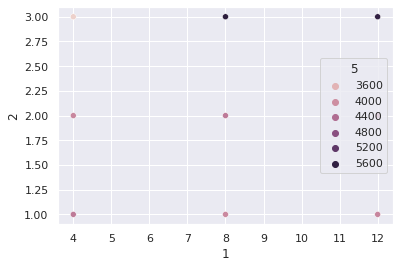

In [ ]:
#Visualization
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

sns.scatterplot(data = result, x = result[1], y = result[2], hue = result[5])


In [ ]:
sns.barplot(data = result, x = result[2], y = result[5])

ValueError: ignored

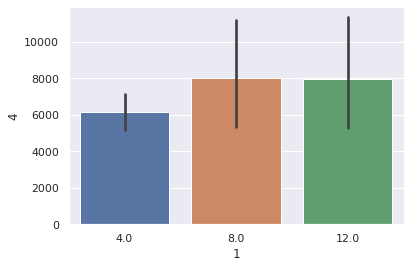

In [ ]:
sns.barplot(data=result, x = result[1], y = result[4])

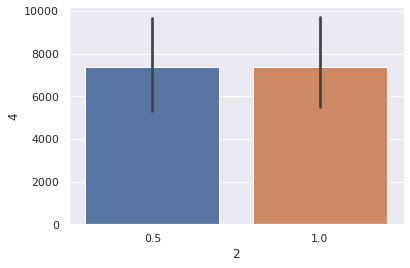

In [ ]:
sns.barplot(data=result, x = result[2], y = result[4])

In [ ]:
win = result.nsmallest(4, 4)
win

,0,1,2,3,4,5
0,0.1,4.0,3.0,0.999913,1.076167e+07,3280.498881
0,0.1,8.0,1.0,0.999868,1.640895e+07,4050.796590
0,0.1,4.0,2.0,0.999866,1.663035e+07,4078.032046
0,0.1,12.0,1.0,0.999866,1.669085e+07,4085.443626


In [ ]:

import numpy as np
Y_true = [1,1,2,2,4]
Y_pred = [0.6,1.29,1.99,2.69,3.4] 


MSE = np.square(np.subtract(Y_true,Y_pred)).mean()